In [136]:
import math
import sklearn.metrics.pairwise as sk
from cvxopt import matrix, solvers
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [137]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
pwd

'/atlas/u/kechoi/multi-fairgen/src'

In [139]:
cd /atlas/u/kechoi/libTLDA

/atlas/u/kechoi/libTLDA


# Dataset

In [140]:
import torch
from sklearn.linear_model import LogisticRegression

In [141]:
rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/source.npz')
X = rec['x']
y = rec['y']

rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/target.npz')
Z = rec['x']
u = rec['y']

rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/target_test.npz')
Z_test = rec['x']
u_test = rec['y']

In [142]:
from libtlda.iw import ImportanceWeightedClassifier

In [165]:
kmm = ImportanceWeightedClassifier(weight_estimator='kmm', bandwidth=0.01)
weights = kmm.iwe_kernel_mean_matching(X, Z)

     pcost       dcost       gap    pres   dres
 0:  4.9900e+02 -3.2216e+04  3e+04  6e-16  1e+03
 1:  4.8932e+02 -3.1317e+03  4e+03  1e-15  1e+02
 2:  4.7042e+02  3.2330e+02  1e+02  2e-14  2e-14
 3:  4.6893e+02  4.6742e+02  2e+00  1e-14  3e-14
 4:  4.6888e+02  4.6886e+02  2e-02  1e-14  7e-14
 5:  4.6888e+02  4.6888e+02  2e-04  3e-14  7e-14
Optimal solution found.


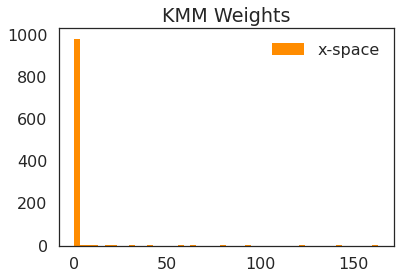

In [144]:
# _ = plt.hist(1/z_weights, bins=50, label='1/z-space')
_ = plt.hist(weights, bins=50, label='x-space', color='darkorange')

# _ = plt.hist(z_weights, bins=50, label='z-space')
# plt.yscale('log')

plt.title('KMM Weights')
plt.legend()

In [166]:
clf = LogisticRegression()
clf.fit(X, y, sample_weight=weights)
pred_adapt = clf.predict(Z)

# Train a naive logistic regressor
lr = LogisticRegression().fit(X, y)

# Make predictions
pred_naive = lr.predict(Z)


# Compute error rates
print('Error naive: ' + str(np.mean(pred_naive != u, axis=0)))
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))

Error naive: 0.297
Error adapt: 0.297


In [167]:
pred_adapt_test = clf.predict(Z_test)
pred_naive_test = lr.predict(Z_test)

# Compute error rates
print('Error naive: ' + str(np.mean(pred_naive_test != u_test, axis=0)))
print('Error adapt: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error naive: 0.286
Error adapt: 0.288


What about the flow?

In [147]:
cd ../multi-fairgen/src/

/atlas/u/kechoi/multi-fairgen/src


In [148]:
device = 'cpu'
restore_file = 'flows/results/kmm_flow/'
state = torch.load(os.path.join(restore_file, "best_model_checkpoint.pt"), map_location=device)
print(state['epoch'])

85


In [149]:
from flows.models.maf import MAF

def load_flow():
    model = MAF(5, 
                2, 
                100, 
                1, 
                None, 
                'relu', 
                'sequential', 
                batch_norm=True)
    restore_file = 'flows/results/kmm_flow/'
    state = torch.load(os.path.join(restore_file, "model_checkpoint.pt"), map_location=device)
    model.load_state_dict(state['model_state'])
    model = model.to(device)
    return model

flow = load_flow()
flow.eval()

MAF(
  (net): FlowSequential(
    (0): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (1): BatchNorm()
    (2): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (3): BatchNorm()
    (4): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      

Text(0.5, 1.0, 'Source + Target')

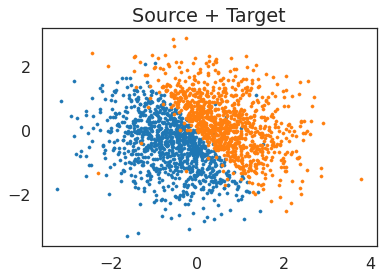

In [159]:
# encode data points
flow_train_x, _ = flow.forward(torch.from_numpy(X).cpu().float())
flow_test_x, _ = flow.forward(torch.from_numpy(Z).cpu().float())

plt.scatter(flow_train_x[:,0].data.cpu().numpy(), flow_train_x[:,1].data.cpu().numpy(), s=10)
plt.scatter(flow_test_x[:,0].data.cpu().numpy(), flow_test_x[:,1].data.cpu().numpy(), s=10)

plt.title('Source + Target')

### train KMM on z

In [151]:
flow_x = flow_train_x.data.cpu().numpy()
flow_z = flow_test_x.data.cpu().numpy()

In [176]:
kmm = ImportanceWeightedClassifier(weight_estimator='kmm', bandwidth=0.01)
z_weights = kmm.iwe_kernel_mean_matching(flow_x, flow_z)

     pcost       dcost       gap    pres   dres
 0:  4.9904e+02 -3.2216e+04  3e+04  1e-15  1e+03
 1:  4.8935e+02 -3.1317e+03  4e+03  2e-15  1e+02
 2:  4.7045e+02  3.2334e+02  1e+02  2e-14  8e-14
 3:  4.6896e+02  4.6745e+02  2e+00  1e-15  8e-14
 4:  4.6891e+02  4.6889e+02  2e-02  5e-15  9e-14
 5:  4.6891e+02  4.6891e+02  2e-04  9e-15  1e-13
Optimal solution found.


In [177]:
# Train via KMM
# from sklearn.linear_model import LogisticRegressionCV
# clf = LogisticRegressionCV(cv=5, solver='lbfgs')
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X, y, sample_weight=(z_weights))
pred_adapt = clf.predict(Z)

# Compute error rates
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))

Error adapt: 0.297


In [178]:
# target test
flow_test_real, _ = flow(torch.from_numpy(Z_test).float().cpu())
pred_adapt_test = clf.predict(Z_test)
print('Error adapt in z-space: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error adapt in z-space: 0.288


Target
- Error naive: 0.297
- Error adapt: 0.259

Target (test)
- Error naive: 0.286
- Error adapt: 0.247

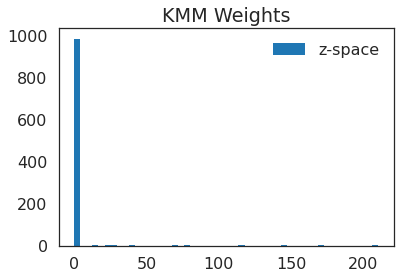

In [129]:
# _ = plt.hist(weights, bins=50, label='x-space')
# _ = plt.hist(z_weights, bins=50, label='z-space')
# plt.yscale('log')

plt.title('KMM Weights')
plt.legend()
# 1/z_weights

---------

### What if I do the entire thing in z-space?

In [29]:
# Train via KMM
clf = LogisticRegression()
clf.fit(flow_x, y, sample_weight=z_weights)
pred_adapt = clf.predict(flow_z)

# Compute error rates
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))

Error adapt: 0.638


In [30]:
# target test
flow_test_real, _ = flow(torch.from_numpy(Z_test).float().cuda())
pred_adapt_test = clf.predict(flow_test_real.data.cpu().numpy())
print('Error adapt in z-space: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error adapt in z-space: 0.629


----

### naive LR in z-space

In [26]:
lr = LogisticRegression()
lr.fit(flow_x, y)
pred_naive = lr.predict(flow_z)

# Compute error rates
print('Error naive in z-space: ' + str(np.mean(pred_naive != u, axis=0)))

Error naive in z-space: 0.635


In [28]:
# target test
flow_test_real, _ = flow(torch.from_numpy(Z_test).float().cpu())
pred_naive_test = lr.predict(flow_test_real.data.cpu().numpy())
print('Error naive (test) in z-space: ' + str(np.mean(pred_naive_test != u_test, axis=0)))

Error naive (test) in z-space: 0.629


---

# Weights

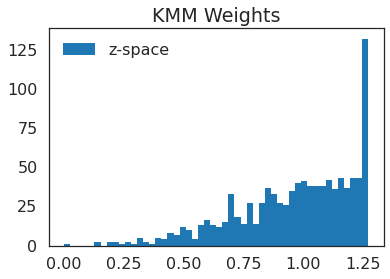

In [96]:
# _ = plt.hist(weights, bins=50, label='x-space')
_ = plt.hist(z_weights, bins=50, label='z-space')
# plt.yscale('log')

plt.title('KMM Weights')
plt.legend()

# Sanity check: different KMM repo

In [193]:
def kmm(Xtrain, Xtest, sigma=0.5):
    n_tr = len(Xtrain)
    n_te = len(Xtest)

    # calculate Kernel
    print('Computing kernel for training data ...')
    K_ns = sk.rbf_kernel(Xtrain, Xtrain, sigma)
    # make it symmetric
    K = 0.9 * (K_ns + K_ns.transpose())

    # calculate kappa
    print('Computing kernel for kappa ...')
    kappa_r = sk.rbf_kernel(Xtrain, Xtest, sigma)
    ones = np.ones(shape=(n_te, 1))
    kappa = np.dot(kappa_r, ones)
    kappa = -(float(n_tr) / float(n_te)) * kappa

    # calculate eps
    eps = (math.sqrt(n_tr) - 1) / math.sqrt(n_tr)

    # constraints
    A0 = np.ones(shape=(1, n_tr))
    A1 = -np.ones(shape=(1, n_tr))
    A = np.vstack([A0, A1, -np.eye(n_tr), np.eye(n_tr)])
    b = np.array([[n_tr * (eps + 1), n_tr * (eps - 1)]])
    b = np.vstack([b.T, -np.zeros(shape=(n_tr, 1)), np.ones(shape=(n_tr, 1)) * 1000])

    print('Solving quadratic program for beta ...')
    P = matrix(K, tc='d')
    q = matrix(kappa, tc='d')
    G = matrix(A, tc='d')
    h = matrix(b, tc='d')
    beta = solvers.qp(P, q, G, h)
    return [i for i in beta['x']]

In [125]:
weights_2 = kmm(X, Z)

Computing kernel for training data ...
Computing kernel for kappa ...
Solving quadratic program for beta ...
     pcost       dcost       gap    pres   dres
 0: -1.1596e+04 -3.7355e+08  4e+08  4e-03  5e-14
 1:  2.6465e+05 -7.2321e+06  8e+06  6e-05  3e-14
 2:  8.7487e+04 -1.4748e+06  2e+06  9e-06  1e-14
 3: -2.4806e+04 -3.7215e+05  3e+05  5e-07  6e-15
 4: -7.3912e+04 -1.2689e+05  5e+04  1e-08  5e-15
 5: -8.2865e+04 -1.0058e+05  2e+04  4e-09  2e-15
 6: -8.5926e+04 -9.1583e+04  6e+03  7e-10  1e-15
 7: -8.6667e+04 -8.9871e+04  3e+03  7e-11  4e-16
 8: -8.7136e+04 -8.7963e+04  8e+02  1e-11  5e-16
 9: -8.7150e+04 -8.7943e+04  8e+02  1e-11  4e-16
10: -8.7260e+04 -8.7539e+04  3e+02  4e-12  3e-16
11: -8.7305e+04 -8.7360e+04  5e+01  2e-16  3e-16
12: -8.7315e+04 -8.7321e+04  7e+00  2e-16  2e-16
13: -8.7316e+04 -8.7320e+04  5e+00  2e-16  2e-16
14: -8.7316e+04 -8.7318e+04  1e+00  2e-16  2e-16
15: -8.7317e+04 -8.7317e+04  9e-01  2e-16  2e-16
16: -8.7317e+04 -8.7317e+04  3e-01  2e-16  3e-16
17: -8.731

In [126]:
z_weights_2 = kmm(flow_x.astype('float64'), flow_z.astype('float64'))

Computing kernel for training data ...
Computing kernel for kappa ...
Solving quadratic program for beta ...
     pcost       dcost       gap    pres   dres
 0: -2.3013e+04 -3.3311e+08  3e+08  6e-03  2e-14
 1:  2.9397e+05 -6.5709e+06  7e+06  9e-05  4e-15
 2:  2.5638e+04 -7.9729e+05  8e+05  2e-16  2e-15
 3: -7.7831e+04 -3.2229e+05  2e+05  2e-16  2e-15
 4: -1.0971e+05 -1.9263e+05  8e+04  2e-16  7e-16
 5: -1.1896e+05 -1.4336e+05  2e+04  2e-16  4e-16
 6: -1.1966e+05 -1.4227e+05  2e+04  2e-16  3e-16
 7: -1.2182e+05 -1.3083e+05  9e+03  2e-16  2e-16
 8: -1.2234e+05 -1.2956e+05  7e+03  2e-16  2e-16
 9: -1.2256e+05 -1.2822e+05  6e+03  2e-16  1e-16
10: -1.2320e+05 -1.2526e+05  2e+03  2e-16  1e-16
11: -1.2325e+05 -1.2519e+05  2e+03  2e-16  1e-16
12: -1.2357e+05 -1.2393e+05  4e+02  2e-16  1e-16
13: -1.2361e+05 -1.2381e+05  2e+02  2e-16  1e-16
14: -1.2362e+05 -1.2381e+05  2e+02  2e-16  1e-16
15: -1.2364e+05 -1.2373e+05  9e+01  2e-16  1e-16
16: -1.2366e+05 -1.2368e+05  2e+01  2e-16  1e-16
17: -1.236

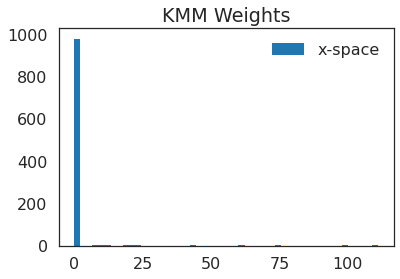

In [133]:
_ = plt.hist(weights_2, bins=50, label='x-space')
# _ = plt.hist(z_weights_2, bins=50, label='z-space')
# plt.yscale('log')

plt.title('KMM Weights')
plt.legend()

In [131]:
z_weights_2

[5.132518563242286,
 4.28759987625782e-05,
 112.26422166925455,
 21.586185289549213,
 76.86226596149547,
 6.874152427390686e-05,
 68.6079812402533,
 0.0003367698994847133,
 51.288390914938425,
 77.69791432388737,
 4.0635585197207234e-05,
 9.137002336071264e-05,
 7.556553283418143e-05,
 0.000984606549562158,
 8.52924472004044e-05,
 7.694672140132654e-05,
 8.010400346044027e-05,
 9.940318734519873e-06,
 6.394108320954933e-05,
 4.54031194409127e-05,
 1.540528733165514e-05,
 1.2869922738631179e-05,
 1.2966194746253098e-05,
 9.968968492334941e-05,
 7.872276686502989e-05,
 0.5464639188391369,
 4.532559140777198e-05,
 1.4933371044638288e-05,
 0.0008094025137557726,
 0.0001377389061687837,
 2.1892482319588995e-05,
 2.4887161556837485e-05,
 4.5361205648592924e-05,
 0.000108408348324212,
 1.6480828175044796e-05,
 9.808138486631345e-05,
 3.1715419469679264e-05,
 2.184938059381314e-05,
 9.335494681423995e-06,
 0.0001852056068962103,
 1.8716033826450455e-05,
 4.099346713460017e-05,
 6.6554522616811

In [191]:
bandwidths = [0.0025, 0.005, 0.01, 0.05, 0.1, 0.15, 0.25, 0.5, 0.75, 1.0]

In [209]:
min_bandwidth_z = 0.01
min_adapt_error_z = float('inf')
min_weights_z = None
for bandwidth in bandwidths:
#     kmm = ImportanceWeightedClassifier(weight_estimator='kmm', bandwidth=bandwidth)
#     weights = kmm.iwe_kernel_mean_matching(flow_x, flow_z)
    weights = kmm(flow_x.astype('float64'), flow_z.astype('float64'), sigma=(1/(bandwidth ** 2)))

    clf = LogisticRegression()
    clf.fit(X, y, sample_weight=weights)
    pred_adapt = clf.predict(Z)

    # Train a naive logistic regressor
    lr = LogisticRegression().fit(X, y)

    # Make predictions
    pred_naive = lr.predict(Z)


    # Compute error rates
    print('Error naive: ' + str(np.mean(pred_naive != u, axis=0)))
    print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))


    pred_adapt_test = clf.predict(Z_test)
    pred_naive_test = lr.predict(Z_test)
    # Compute error rates
    naive_error = np.mean(pred_naive_test != u_test, axis=0)
    adapt_error = np.mean(pred_adapt_test != u_test, axis=0)
    if adapt_error < min_adapt_error_z:
        min_bandwidth_z = bandwidth
        min_adapt_error_z = adapt_error
        min_weights_z = weights
#     print('Error naive: ' + str(naive_error))
#     print('Error adapt: ' + str(adapt_error))

Computing kernel for training data ...
Computing kernel for kappa ...
Solving quadratic program for beta ...
     pcost       dcost       gap    pres   dres
 0:  2.0234e+03 -4.6999e+08  5e+08  4e-16  1e-09
 1:  2.0187e+03 -5.5575e+06  6e+06  3e-15  2e-10
 2:  1.9897e+03 -6.0783e+04  6e+04  2e-15  7e-13
 3:  9.1851e+02 -3.2552e+03  4e+03  2e-15  7e-13
 4:  1.5926e+02 -2.9151e+02  5e+02  1e-15  2e-13
 5:  2.5487e+01 -3.1762e+01  6e+01  2e-15  5e-14
 6:  3.8831e+00 -4.4106e+00  8e+00  5e-15  1e-14
 7:  9.2217e-01 -1.0566e+00  2e+00  5e-16  3e-15
 8:  2.8131e+00 -4.0494e-02  3e+00  5e-16  6e-14
 9:  1.1290e+00  8.7194e-01  3e-01  8e-16  3e-14
10:  9.0643e-01  9.0212e-01  4e-03  3e-15  2e-14
11:  9.0249e-01  9.0245e-01  4e-05  4e-15  3e-16
12:  9.0245e-01  9.0245e-01  4e-07  3e-16  7e-15
Optimal solution found.
Error naive: 0.297
Error adapt: 0.943
Computing kernel for training data ...
Computing kernel for kappa ...
Solving quadratic program for beta ...
     pcost       dcost       gap   

19: -2.5131e+04 -2.5131e+04  6e-02  2e-16  3e-16
20: -2.5131e+04 -2.5131e+04  6e-03  2e-16  4e-16
Optimal solution found.
Error naive: 0.297
Error adapt: 0.229
Computing kernel for training data ...
Computing kernel for kappa ...
Solving quadratic program for beta ...
     pcost       dcost       gap    pres   dres
 0:  2.8277e+03 -4.0434e+08  4e+08  4e-03  8e-15
 1:  2.1619e+05 -8.8461e+06  9e+06  6e-05  3e-14
 2:  1.1309e+05 -1.4442e+06  2e+06  7e-06  6e-15
 3:  3.4061e+04 -4.9406e+05  5e+05  2e-16  2e-15
 4: -2.5083e+04 -1.7208e+05  1e+05  2e-16  3e-15
 5: -4.1977e+04 -9.6190e+04  5e+04  2e-16  1e-15
 6: -4.5715e+04 -8.2733e+04  4e+04  2e-16  6e-16
 7: -5.0678e+04 -6.0835e+04  1e+04  2e-16  6e-16
 8: -5.2199e+04 -5.5475e+04  3e+03  2e-16  4e-16
 9: -5.2220e+04 -5.5432e+04  3e+03  2e-16  4e-16
10: -5.2565e+04 -5.4463e+04  2e+03  2e-16  3e-16
11: -5.2854e+04 -5.3531e+04  7e+02  2e-16  2e-16
12: -5.2933e+04 -5.3306e+04  4e+02  2e-16  2e-16
13: -5.2995e+04 -5.3124e+04  1e+02  2e-16  2e-

In [210]:
min_bandwidth

0.01

In [215]:
min_bandwidth = 0.01
min_adapt_error = float('inf')
min_weights = None
for bandwidth in bandwidths:
#     kmm = ImportanceWeightedClassifier(weight_estimator='kmm', bandwidth=bandwidth)
#     weights = kmm.iwe_kernel_mean_matching(X, Z)
    weights = kmm(X, Z, sigma=(1/(bandwidth ** 2)))

    clf = LogisticRegression()
    clf.fit(X, y, sample_weight=weights)
    pred_adapt = clf.predict(Z)

    # Train a naive logistic regressor
    lr = LogisticRegression().fit(X, y)

    # Make predictions
    pred_naive = lr.predict(Z)


    # Compute error rates
    print('Error naive: ' + str(np.mean(pred_naive != u, axis=0)))
    print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))


    pred_adapt_test = clf.predict(Z_test)
    pred_naive_test = lr.predict(Z_test)
    # Compute error rates
    naive_error = np.mean(pred_naive_test != u_test, axis=0)
    adapt_error = np.mean(pred_adapt_test != u_test, axis=0)
    if adapt_error < min_adapt_error:
        min_bandwidth = bandwidth
        min_adapt_error = adapt_error
        min_weights = weights
#     print('Error naive: ' + str(naive_error))
#     print('Error adapt: ' + str(adapt_error))

Computing kernel for training data ...
Computing kernel for kappa ...
Solving quadratic program for beta ...
     pcost       dcost       gap    pres   dres
 0:  2.0214e+03 -4.6999e+08  5e+08  5e-16  2e-09
 1:  2.0168e+03 -5.5567e+06  6e+06  2e-15  2e-10
 2:  1.9873e+03 -6.0761e+04  6e+04  1e-15  1e-11
 3:  9.1723e+02 -3.2610e+03  4e+03  1e-15  8e-13
 4:  1.5919e+02 -2.9109e+02  5e+02  1e-15  2e-13
 5:  2.5476e+01 -3.1743e+01  6e+01  3e-15  1e-14
 6:  3.8814e+00 -4.4087e+00  8e+00  5e-16  1e-14
 7:  9.2130e-01 -1.0556e+00  2e+00  1e-15  4e-15
 8:  2.8116e+00 -3.9897e-02  3e+00  1e-15  2e-13
 9:  1.1283e+00  8.7138e-01  3e-01  2e-15  6e-14
10:  9.0568e-01  9.0137e-01  4e-03  2e-15  2e-14
11:  9.0173e-01  9.0169e-01  4e-05  7e-16  2e-15
12:  9.0169e-01  9.0169e-01  4e-07  5e-16  2e-15
Optimal solution found.
Error naive: 0.297
Error adapt: 0.944
Computing kernel for training data ...
Computing kernel for kappa ...
Solving quadratic program for beta ...
     pcost       dcost       gap   

Solving quadratic program for beta ...
     pcost       dcost       gap    pres   dres
 0:  1.5484e+04 -4.2411e+08  4e+08  2e-03  1e-13
 1:  1.0919e+05 -6.6587e+06  7e+06  2e-05  1e-13
 2:  5.3838e+04 -9.6117e+05  1e+06  3e-06  2e-14
 3:  1.5495e+04 -2.1659e+05  2e+05  2e-16  5e-15
 4: -1.9114e+04 -4.9539e+04  3e+04  2e-16  8e-15
 5: -2.5321e+04 -3.3189e+04  8e+03  2e-16  3e-15
 6: -2.7146e+04 -2.8985e+04  2e+03  2e-16  2e-15
 7: -2.7532e+04 -2.7883e+04  4e+02  2e-16  8e-16
 8: -2.7605e+04 -2.7652e+04  5e+01  2e-16  4e-16
 9: -2.7613e+04 -2.7642e+04  3e+01  2e-16  3e-16
10: -2.7618e+04 -2.7625e+04  7e+00  2e-16  3e-16
11: -2.7619e+04 -2.7625e+04  6e+00  2e-16  2e-16
12: -2.7619e+04 -2.7622e+04  2e+00  2e-16  2e-16
13: -2.7620e+04 -2.7621e+04  1e+00  2e-16  2e-16
14: -2.7620e+04 -2.7620e+04  3e-01  2e-16  3e-16
15: -2.7620e+04 -2.7620e+04  3e-01  2e-16  3e-16
16: -2.7620e+04 -2.7620e+04  1e-01  2e-16  3e-16
17: -2.7620e+04 -2.7620e+04  9e-02  2e-16  4e-16
18: -2.7620e+04 -2.7620e+04  3e

In [223]:
print('min adapt error X-space: ', min_adapt_error)
print('corresponding bandwidth: ', min_bandwidth)

min adapt error X-space:  0.153
corresponding bandwidth:  0.1


In [224]:
print('min adapt error Z-space: ', min_adapt_error_z)
print('corresponding bandwidth: ', min_bandwidth_z)

min adapt error Z-space:  0.101
corresponding bandwidth:  0.75


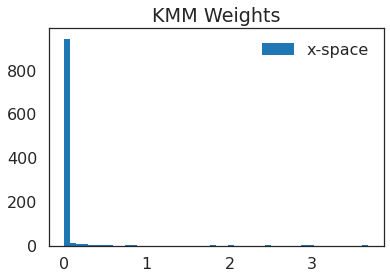

In [218]:
_ = plt.hist(min_weights, bins=50, label='x-space')
# _ = plt.hist(z_weights_2, bins=50, label='z-space')
# plt.yscale('log')

plt.title('KMM Weights')
plt.legend()

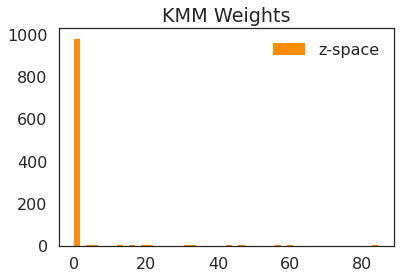

In [221]:
_ = plt.hist(min_weights_z, bins=50, label='z-space', color='darkorange')
# _ = plt.hist(z_weights_2, bins=50, label='z-space')
# plt.yscale('log')

plt.title('KMM Weights')
plt.legend()